In [1]:
%reset -f
%matplotlib inline

In [2]:
import pyross
import numpy as np
import matplotlib.pyplot as plt

# Introduction: Forecast for SIR model with stochastic parameters

In this notebook, we consider the SIR model. 

We assume that the parameters 

* $\beta$ (probability of infection on contact) and 
* $\gamma$ (rate of recovery for infected individuals) 

are not known exactly, but rather are characterized by a 2D Gaussian distribution with known mean and covariance matrix. Since $\beta$, $\gamma >0$, the Gaussian distribution is set to zero if any of the two parameters is $\leq 0$.

**We now illustrate how uncertainties in the parameters $(\beta, \gamma)$ affect the predictions of the SIR model.**

For this we simulate the SIR model $Ns = 500$ times; for each simulation the parameters $(\beta,\gamma)$ are sampled from the given 2D Gaussian distribution. The resulting 500 trajectories are shown together with their mean, standard deviation, median, and 5 as well as 95 percentiles.

We perform this analysis for 

1. the deterministic SIR model,
2. the stochastic SIR model (simulated with a Gillespie SSA algorithm), and
3. the stochastic SIR model (simulated with a tau-leaping algorithm).

# Define model parameters and initialise pyross.forecast.SIR

In [3]:
#Ex1: M=1, SIR

M = 1                  # the SIR model has no age structure
Ni = 50000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

alpha = 0.0            # fraction of asymptomatic infectives 
fsa   = 1              # the self-isolation parameter 

Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([500])    # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and output datapoints
Tf = 100;  Nt=Tf+1



# These are the parameters that we sample stochastically
# means
beta  = 0.5            # infection rate
gamma = 1/14.           # recovery rate 
# covariances (chosen values are for illustrative purposes)
cov_beta_beta = 0.1
cov_beta_gIa = 0.002
cov_gIa_gIa = 0.0001


# Define parameters for simulations
parameters = {'alpha':alpha, 'beta':beta,'fsa':fsa,
             'gIa':gamma,'gIs':gamma,
             'cov_beta_beta':cov_beta_beta,
             'cov_beta_gIa':cov_beta_gIa,
             'cov_gIa_gIa':cov_gIa_gIa}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SIR(parameters, M, Ni)


# Number of simulations over which we average
Ns = 500 

In [4]:
# Define a function which we use below to plot simulation results
def plot_result(result,
                percentile=-1,
                plot_index = 2, # which time series should be plotted? 
               filename='None'): # set filename for saving figures
    # plot_index = 0: susceptibles
    # plot_index = 1: infectives, asymptomatic
    # plot_index = 2: infectives, symptomatic
    if plot_index == 0:
        ylabel = r'$N_S$'
    elif plot_index == 1:
        ylabel = r'$N_{I,a}$'
    elif plot_index == 2:
        ylabel = r'$N_I$'
    else:
        raise RuntimeError("plot_index should be 0, 1, or 2.")
    #
    fontsize=25
    #
    # Scatterplot of used parameters
    #
    sample_parameters = result['sample_parameters'].T
    beta = result['beta']
    gI = result['gIa']
    #
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(r'Samples for stochastic $\beta$, $\gamma$',
                 y=1.05,
                fontsize=fontsize)
    ax.axvline(beta,color='limegreen',ls='--',lw=2,label=r'$\langle \beta \rangle$')
    ax.axhline(gI,color='dodgerblue',ls='--',lw=2,label=r'$\langle \gamma \rangle$')
    ax.scatter(sample_parameters[0], sample_parameters[1] ,
               label='sampled data',
               color='black',s=10) #, c = truth)
    ax.set_xlabel(r'$\beta$',fontsize=fontsize)
    ax.set_ylabel(r'$\gamma$',fontsize=fontsize)
    ax.set_xlim(0,1.05*np.max(sample_parameters[0]))
    ax.set_ylim(0,1.05*np.max(sample_parameters[1]))
    ax.legend(loc='best',fontsize=15)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_samples.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #
    #
    #
    trajectories = result['X']
    t_arr = result['t']
    traj_mean = result['X_mean']
    traj_std = result['X_std']
    #
    #
    # Plot trajectories
    #
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(r'Simulation results for stochastic $\beta$, $\gamma$',
                 y=1.05,
                fontsize=fontsize)
    for i,e in enumerate(trajectories):
        ax.plot(t_arr,e[plot_index],
                alpha=0.15,
               )
    ax.fill_between(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                    traj_mean[plot_index] + traj_std[plot_index],
                    alpha=0.7,
                    color='limegreen',
                           label='Std deviation')
    ax.plot(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                    alpha=1,
            label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean[plot_index] + traj_std[plot_index],
                    alpha=1,
            #label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean[plot_index],
                    alpha=1,
            lw=2,
            color='black',
           label='Mean')
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    ax.legend(loc='upper right',fontsize=18)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_trajs.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #
    #
    #
    # Plot percentiles
    #
    if percentile > 0:
        percentiles_lower = np.percentile(trajectories[:,plot_index],percentile,axis=0)
        percentiles_upper = np.percentile(trajectories[:,plot_index],100-percentile,axis=0)
        percentiles_median = np.percentile(trajectories[:,plot_index],50,axis=0)
        print("In the following plot, red dashed lines denote {0} and {1} percentiles of the numerical data:".format(percentile,
                                                                                             100-percentile))
        fig, ax = plt.subplots(1,1,figsize=(7,5))
        ax.set_title(r'Simulation results for stochastic $\beta$, $\gamma$',
                     y=1.05,
                    fontsize=fontsize)
        for i,e in enumerate(trajectories):
            ax.plot(t_arr,e[plot_index],
                    alpha=0.15,
                   )
        ax.fill_between(t_arr,percentiles_lower,
                        percentiles_upper,
                        alpha=0.1,
                        color='red',
                               label='Percentiles')
        ax.plot(t_arr,percentiles_lower,
                        alpha=1,
                lw=2,
                label='Percentiles',
                ls='--',
                color='red',
               )
        ax.plot(t_arr,percentiles_upper,
                        alpha=1,
                lw=2,
                color='red',
                ls='--',
               )
        ax.plot(t_arr,percentiles_median,
                        alpha=1,
                lw=2,
                color='red',
               label='Median')
        ax.plot(t_arr,traj_mean[plot_index],
                        alpha=1,
                lw=2,
                color='black',
               label='Mean')
        ax.set_xlim(np.min(t_arr),np.max(t_arr))
        ax.set_ylabel(ylabel,fontsize=fontsize)
        ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
        ax.legend(loc='upper right',fontsize=18)
        plt.show(fig)
        if filename != 'None':
            fig.savefig(filename + '_trajs2.png', bbox_inches='tight',dpi=100)
        plt.close(fig)

# 1. Forecast based on deterministic model

Finished. Time needed for evaluation: 00:00:02


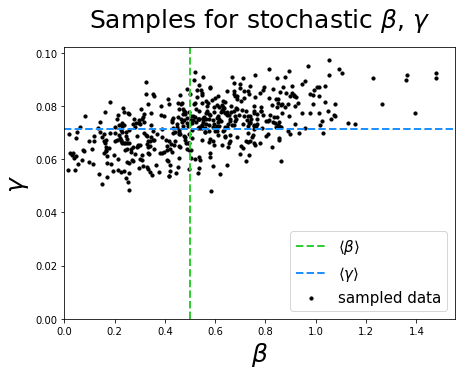

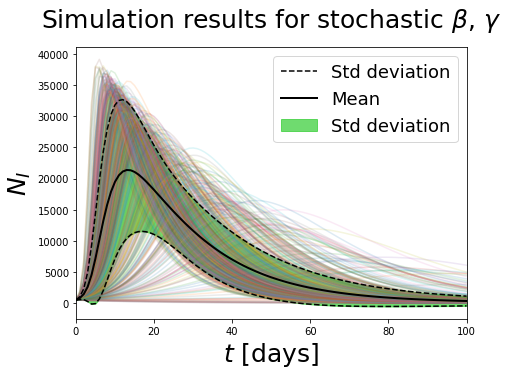

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


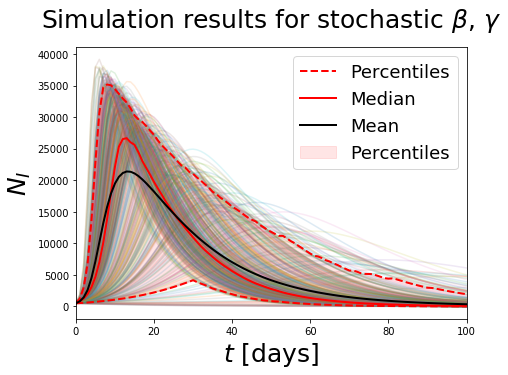

In [5]:
result = model_forecast.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     Ns=Ns) 

plot_result(result,
#            filename='forecast_deterministic',
            percentile=5,
           )

# 2. Forecast based on stochastic Gillespie SSA algorithm

Finished. Time needed for evaluation: 00:08:17


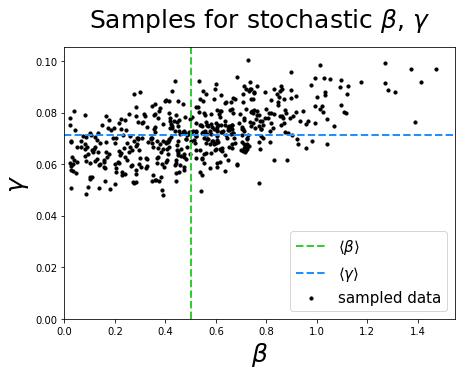

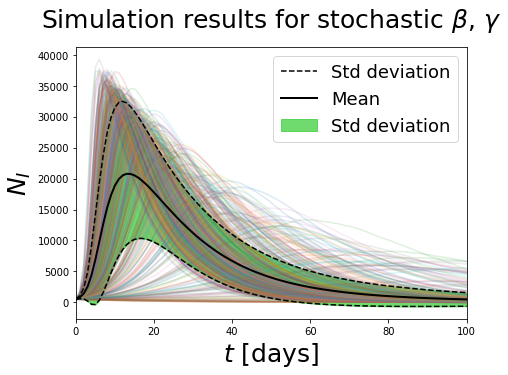

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


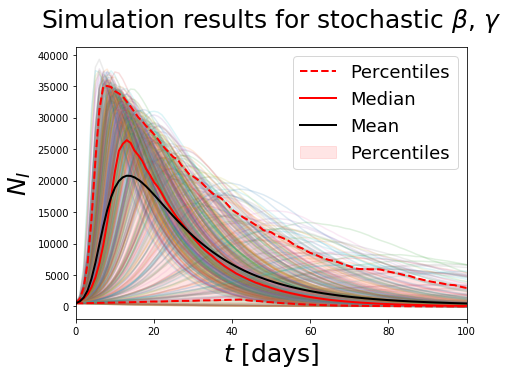

In [6]:
result = model_forecast.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     method='gillespie',
                                     Ns=Ns) 

plot_result(result,
#            filename='forecast_gillespie',
            percentile=5,
           )

# 3. Forecast based on stochastic tau-leaping algorithm

Finished. Time needed for evaluation: 00:00:31


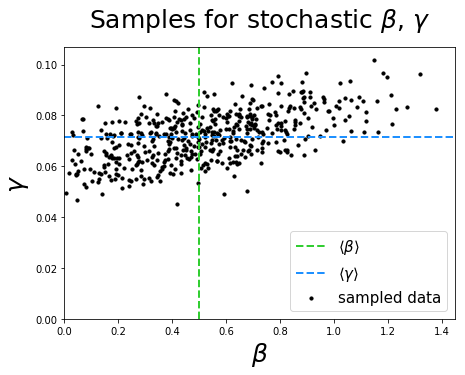

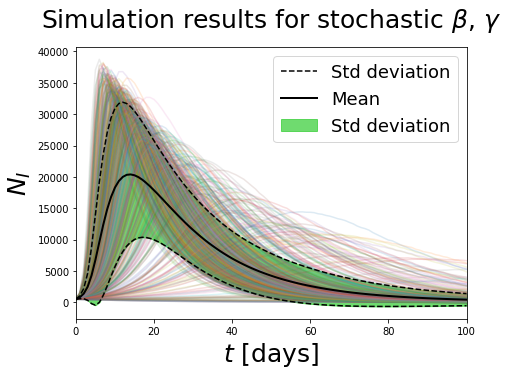

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


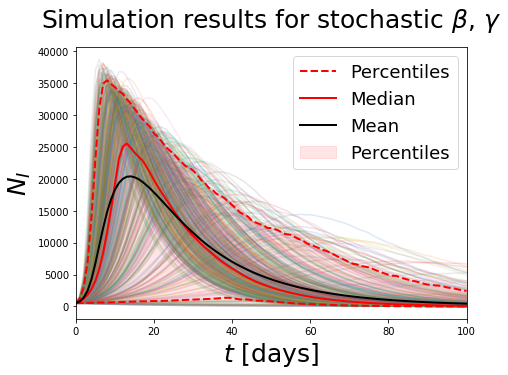

In [7]:
result = model_forecast.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     method='tau-leaping',
                                     Ns=Ns)

plot_result(result,
#            filename='forecast_tauleaping',
            percentile=5,
           )

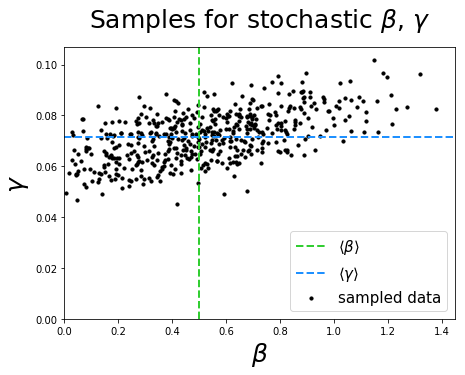

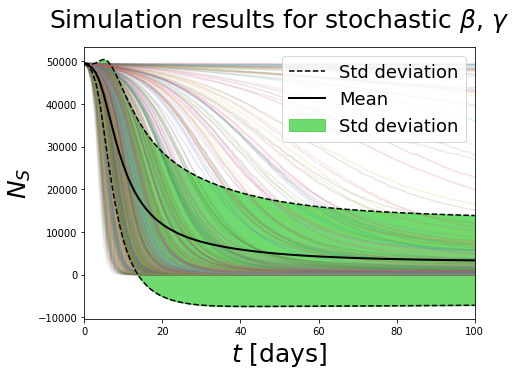

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


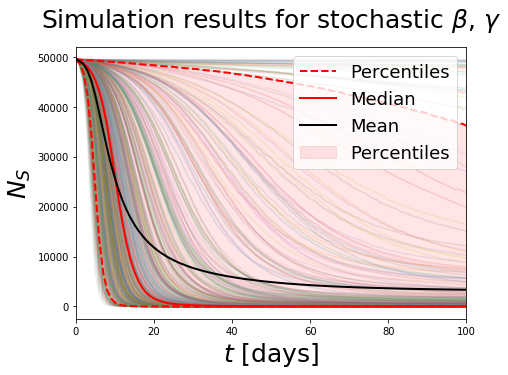

In [8]:
# For the stochastic tau-leaping algorithm, we also plot the time series for 
# the number of susceptibles

plot_result(result,
#            filename='forecast_tauleaping_S',
            plot_index = 0,
            percentile=5,
           )